# Demo on lung dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import q2r_uncertainty
import diff2atlas


Global seed set to 0


In [3]:
import celltypist

In [4]:
## Some utils
def clean_pop_name(string):
   return(''.join(e if e.isalnum() else '_' for e in string))

### Load dataset

In [5]:
if os.path.exists('/home/jupyter/'):
    outpath = '/home/jupyter/mount/gdrive/query2reference/processed_data/'
elif os.path.exists('/home/jovyan/'):
    outpath = '/home/jovyan/mount/gdrive/query2reference/processed_data/'

# h5ad_file = 'lung.h5ad'
# adata = sc.read_h5ad(outpath + h5ad_file)

In [6]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

<AxesSubplot:xlabel='None-donor', ylabel='cell_type'>

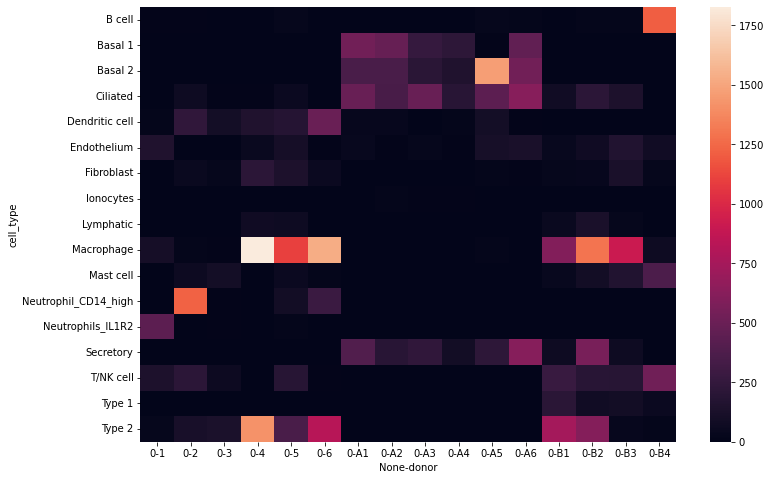

In [8]:
ct_counts = adata.obs[['cell_type', 'donor']].groupby(['cell_type', 'donor']).size().reset_index()
wide_ct_counts = ct_counts.pivot(index='cell_type',columns='donor')
plt.rcParams['figure.figsize'] = [12,8]
sns.heatmap(wide_ct_counts)

### Split into atlas-condition-control and simulate condition-specific pop

In [32]:
population_obs = 'cell_type'
perturb_pop=['Secretory']
batch_obs='batch'
query_batch=['A6']
ctrl_batch=['A5']

q2r_uncertainty.q2r_simulation.simulate_query_reference_batch(
            adata, perturb_pop = perturb_pop, population_obs = population_obs,
            batch_obs = batch_obs, query_batch = query_batch, ctrl_batch=ctrl_batch
        )

## Checks 
any(adata.obs[adata.obs[population_obs].isin(perturb_pop)]['is_train']==1)
any(adata.obs[adata.obs[population_obs].isin(perturb_pop)]['is_ctrl']==1)

False

In [33]:
adata_ref = adata[adata.obs['is_train']==1].copy()
adata_ctrl = adata[adata.obs['is_ctrl']==1].copy()
adata_query = adata[adata.obs['is_test']==1].copy()

In [35]:
## Feature selection on reference only
n_hvgs = 5000
overwrite_models = False

if 'log1p' not in adata_ref.uns.keys():
    sc.pp.normalize_per_cell(adata_ref)
    sc.pp.log1p(adata_ref)

sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=n_hvgs,
    subset=True
)

hvgs = adata_ref.var_names.values

In [36]:
sim_id = f"queryBatch{'-'.join(query_batch)}_ctrlBatch{'-'.join(ctrl_batch)}_perturb_{population_obs}{clean_pop_name('-'.join(perturb_pop))}"
if not os.path.exists(outpath + h5ad_file.split('.h5ad')[0] + "_models"):
    print('bubi')
    os.mkdir(h5ad_file.split('.h5ad')[0] + "_models")

In [38]:
## Train reference model
if not os.path.exists(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_reference_{sim_id}/") or overwrite_models:
    vae_ref = q2r_uncertainty.train_models.train_scVI._train_model(adata_ref, hvgs, batch_col=batch_obs)
    vae_ref.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_reference_{sim_id}/", overwrite=True)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 26031 cells, 5000 vars, 14        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
## Map query datasets 
vae_ctrl_fit = q2r_uncertainty.train_models.train_scVI._fit_model(adata_ctrl, vae_ref, batch_col=batch_obs)
vae_ctrl_fit.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_ctrl_fit_{sim_id}/", overwrite=True)
vae_query_fit_ref = q2r_uncertainty.train_models.train_scVI._fit_model(adata_query, vae_ref, batch_col=batch_obs)
vae_query_fit_ref.save(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_query_fit_reference_{sim_id}/", overwrite=True)


In [41]:
## Load saved mapping models
adata_ctrl = adata_ctrl[:,hvgs].copy()
adata_query = adata_query[:,hvgs].copy()
vae_ctrl_fit       = scvi.model.SCVI.load(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_ctrl_fit_{sim_id}/", adata=adata_ctrl)
vae_query_fit_ref  = scvi.model.SCVI.load(outpath + h5ad_file.split('.h5ad')[0] + f"_models/model_query_fit_reference_{sim_id}/", adata=adata_query)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


INFO:scvi.data._anndata:.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2191 cells, 5000 vars, 15 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2191 cells, 5000 vars, 15 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


INFO:scvi.data._anndata:.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2410 cells, 5000 vars, 2 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2410 cells, 5000 vars, 2 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [42]:
## Fix batch categories 
batch_mappings = adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch'].copy()
adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch']['mapping'] = adata_query.obs[batch_mappings['original_key']].cat.categories.values
batch_mappings = adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch'].copy()

adata_query.uns["_scvi"]['categorical_mappings']['_scvi_batch']['mapping'] = adata_query.obs[batch_mappings['original_key']].cat.categories.values
adata_query.obsm['X_scVI_fit_ref']  = vae_query_fit_ref.get_latent_representation()
adata_ctrl.obsm['X_scVI_fit_ref']  = vae_ctrl_fit.get_latent_representation()

INFO     Using data from adata.layers["counts"]                                              


INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 2410 cells, 5000 vars, 15 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [44]:
adata_ctrl

AnnData object with n_obs × n_vars = 2191 × 5000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'is_train', 'is_test', 'is_ctrl', '_scvi_batch', '_scvi_labels'
    uns: '_scvi'
    obsm: 'X_scVI_fit_ref'
    layers: 'counts'

## Co-embedding of control and query

In [65]:
adata_merged = adata_query.concatenate(adata_ctrl, batch_key='dataset', batch_categories=['condition', 'control'])
adata_merged.obs['is_query_pop'] = adata_merged.obs[population_obs].isin(perturb_pop).astype('int')

In [53]:
sc.pp.neighbors(adata_merged, n_neighbors=30, use_rep="X_scVI_fit_ref")
sc.tl.umap(adata_merged)

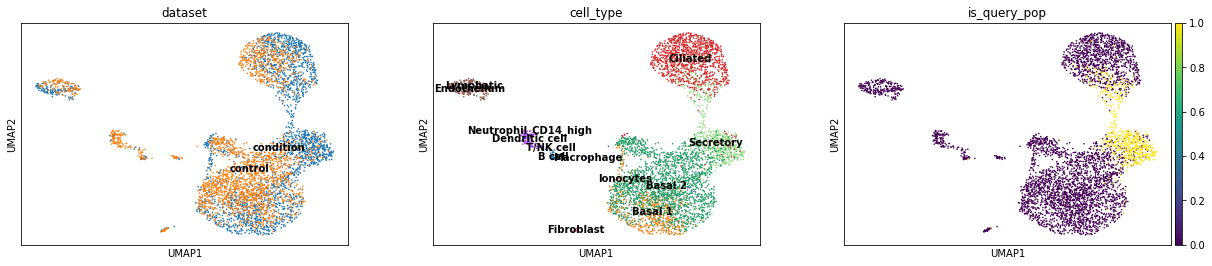

In [66]:
sc.pl.umap(adata_merged, color=['dataset', 'cell_type', 'is_query_pop'], size=10, legend_loc='on data')

In [67]:
adata_ref.write_h5ad(outpath + sim_id + '.reference.h5ad')
adata_merged.write_h5ad(outpath + sim_id + '.coembedding_queries.h5ad')

AnnData object with n_obs × n_vars = 4601 × 5000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'is_train', 'is_test', 'is_ctrl', '_scvi_batch', '_scvi_labels', 'is_query_pop'
    uns: 'neighbors', 'umap', 'dataset_colors', 'cell_type_colors'
    obsm: 'X_scVI_fit_ref', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## CellTypist model

### Train model from reference

In [25]:
adata_ref = sc.read_h5ad(outpath + sim_id + '.reference.h5ad')
adata_merged = sc.read_h5ad(outpath + sim_id + '.coembedding_queries.h5ad')

In [26]:
adata_ref.X = adata_ref.layers['counts'].copy()
sc.pp.normalize_total(adata_ref, target_sum=10000)
sc.pp.log1p(adata_ref)

In [27]:
new_model = celltypist.train(adata_ref, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 1973 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [28]:
new_model.write(outpath + sim_id + '.celltypist_model.pkl')

### Predict labels on query datasets

In [30]:
adata_merged.X = adata_merged.layers['counts'].copy()
sc.pp.normalize_total(adata_merged, target_sum=10000)
sc.pp.log1p(adata_merged)

In [31]:
predictions = celltypist.annotate(adata_merged, 
                                  model = outpath + sim_id + '.celltypist_model.pkl', 
                                  majority_voting = False)

🔬 Input data has 4601 cells and 5000 genes
🔗 Matching reference genes in the model
🧬 1973 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [34]:
adata_merged = predictions.to_adata()

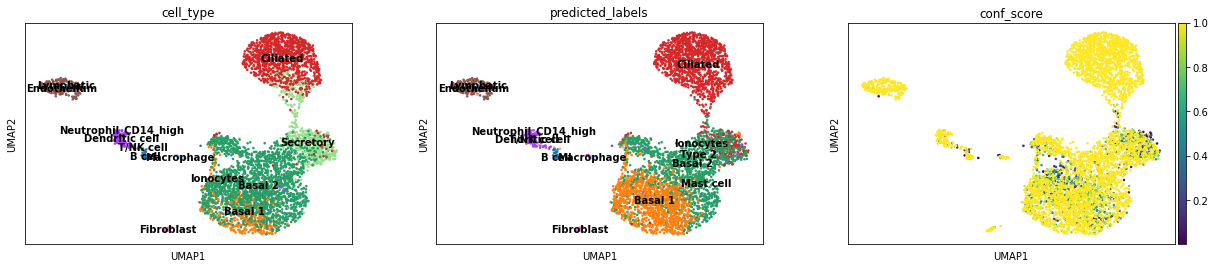

In [39]:
sc.pl.umap(adata_merged, color = ['cell_type', 'predicted_labels', 'conf_score'], legend_loc = 'on data')

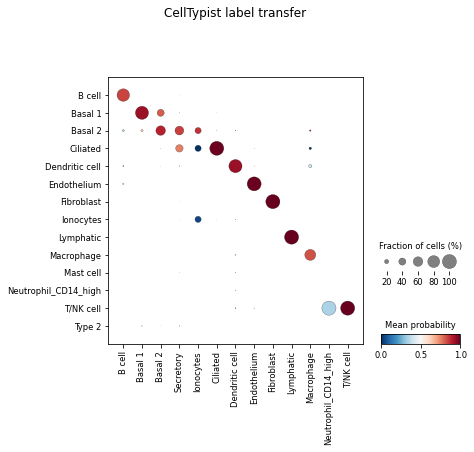

In [37]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'predicted_labels')

In [92]:
sc.tl.leiden(adata_merged)

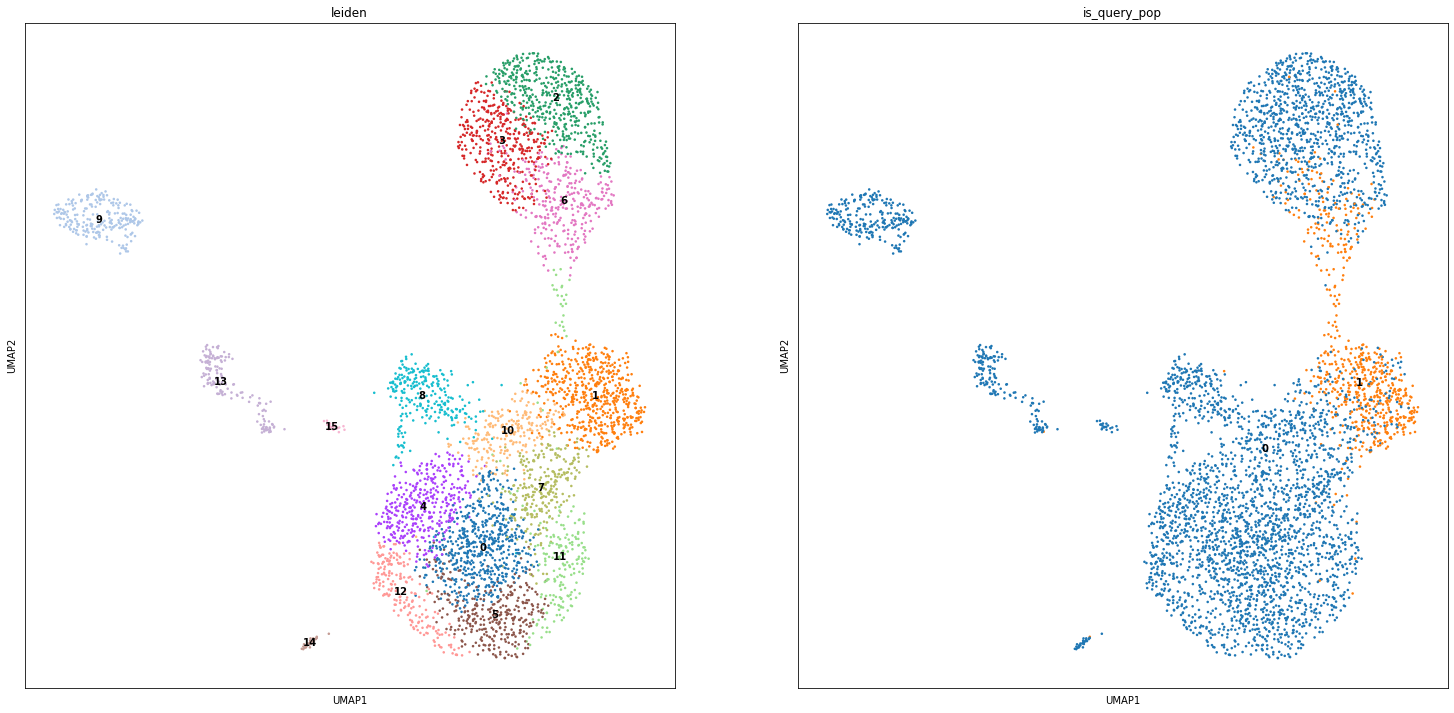

In [104]:
sc.pl.umap(adata_merged, color=['leiden', 'is_query_pop'], legend_loc='on data')

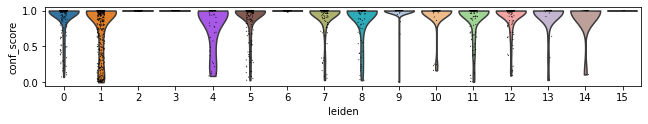

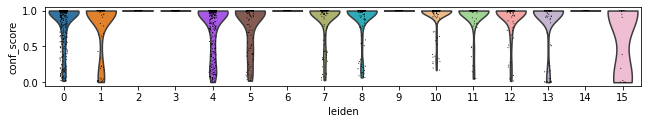

In [105]:
adata_merged.obs['is_query_pop'] = adata_merged.obs['is_query_pop'].astype('category')
with rc_context({'figure.figsize': (9, 1.5)}):
    sc.pl.violin(adata_merged[adata_merged.obs['dataset'] == 'condition'], 'conf_score', groupby='leiden')
    sc.pl.violin(adata_merged[adata_merged.obs['dataset'] == 'control'], 'conf_score', groupby='leiden')

### Differential uncertainty analysis

In [40]:
import milopy.core as milo

In [41]:
milo.make_nhoods(adata_merged, prop=0.1)

(array([23., 41., 80., 73., 59., 53., 23.,  7.,  5.,  6.]),
 array([30. , 36.8, 43.6, 50.4, 57.2, 64. , 70.8, 77.6, 84.4, 91.2, 98. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

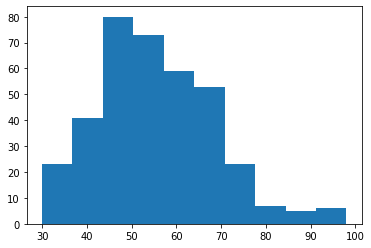

In [47]:
plt.hist(np.array(adata_merged.obsm['nhoods'].sum(0)).ravel())

In [61]:
adata_merged.obsm['cell_nhoods'] = adata_merged.obsm['nhoods'].copy()

In [87]:
diff2atlas.nhood_confidence(adata_merged, confidence_col='conf_score', sample_col='donor')
diff2atlas.make_design(adata_merged, categorical_covariates=['dataset'])
diff2atlas.test_confidence(adata_merged, test_covariate='dataset', method='AUROC')

In [107]:
import milopy.utils

In [118]:
adata_merged.obs['is_query_pop_lab'] = ['query-specific' if x == 1 else 'other' for x in adata_merged.obs['is_query_pop']]

In [119]:
milopy.utils.annotate_nhoods(adata_merged, anno_col='is_query_pop_lab')

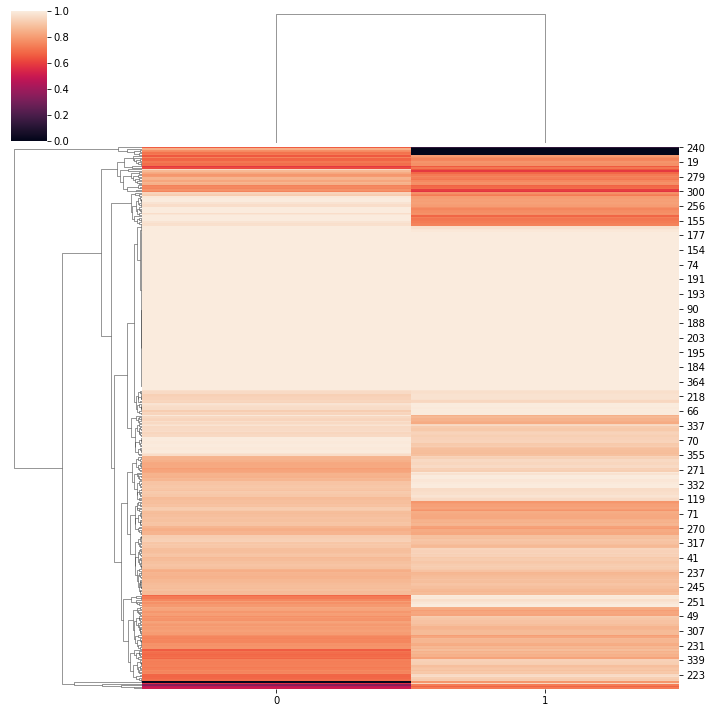

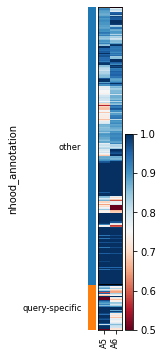

In [166]:
nhood_groupby='nhood_annotation'
order_nhoods = 'cluster'

if order_nhoods == 'cluster':
    nhood_adata = adata_merged.uns['nhood_adata'].copy()
    plt.ioff()
    cl = sns.clustermap(nhood_adata.layers['confidence'])
    ordered_obs = nhood_adata.obs_names[cl.dendrogram_row.reordered_ind]
elif order_nhoods == 'increasing':
    ordered_obs = nhood_adata.obs_names[nhood_adata.layers['confidence'].mean(1).argsort()[::-1]]
elif order_nhoods == 'decreasing':
    ordered_obs = nhood_adata.obs_names[nhood_adata.layers['confidence'].mean(1).argsort()]

    
sc.pl.heatmap(nhood_adata[ordered_obs], nhood_adata.var_names,
        groupby=nhood_groupby, layer='confidence', cmap='RdBu', vmin=0.5)

In [155]:
nhood_adata.layers['confidence'].mean(1).argsort()

array([297, 308, 311, 260,  17, 240, 296,   1,   6,  39,  18, 300,  26,
       268, 235,  33,  64, 294, 287, 299, 232, 252, 285, 115,  19, 313,
       315, 138,  37,  21, 111,  65, 121, 279, 127, 333, 141, 243, 263,
       293, 227,  14, 228, 231,  59,  51, 356, 274, 250, 139, 276, 120,
       295, 135, 123, 277,  45, 262, 172,  55,  44, 223, 267, 241, 357,
       270, 340,  47, 171, 303, 137, 136, 272, 129, 275,  12, 236, 298,
       118, 156, 319, 238, 339,  60, 282, 234,  20, 144,  58,  61,  29,
       325,  32, 307,  49, 265, 350, 259, 258,  43,  69, 345,   8, 157,
        30, 316,  36,  27,  71,  22, 155, 266, 289,  10,  13, 358, 310,
       255, 237, 330,   5,  34, 257, 249, 304,  48, 213, 125, 312, 321,
        35, 280,   9,   4, 271,  40,  72, 323, 233, 328,  57,  25, 133,
       278, 273, 253, 261, 256,  38,  28, 245, 130, 254,  54, 114,  11,
       158, 251,  41, 283, 305, 229, 230, 338, 132, 348,  31, 306, 244,
       317, 222,  56, 224, 131, 269,   3, 122, 322,  16,  23,   

In [140]:
palette = dict(zip(nhood_adata.obs['nhood_annotation'].unique(), nhood_adata.uns['nhood_annotation_colors']))

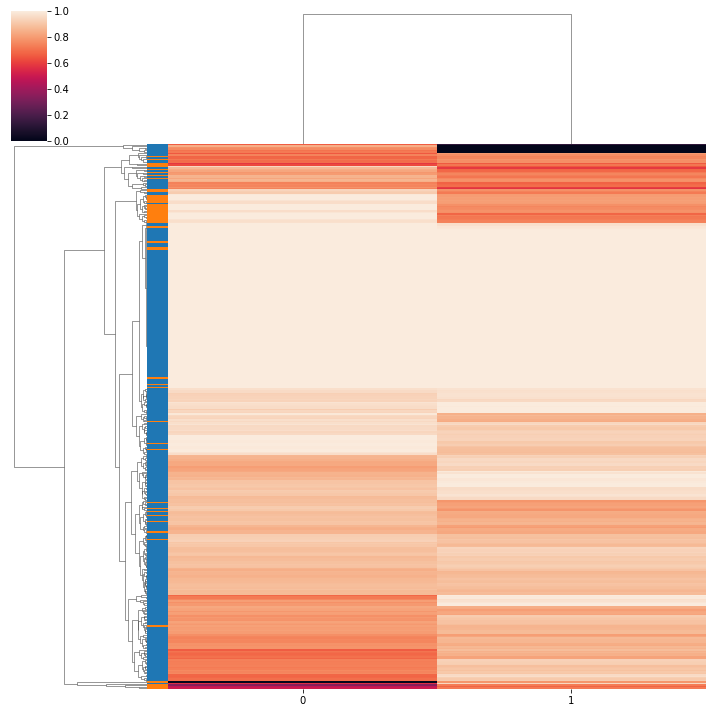

In [142]:
nhood_adata = adata_merged.uns['nhood_adata'].copy()
cl = sns.clustermap(nhood_adata.layers['confidence'], 
               xticklabels=True, yticklabels=False, row_colors=[palette[x] for x in nhood_adata.obs['nhood_annotation']])